# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_style("darkgrid")

# Load the dataset

In [2]:
train=pd.read_excel("Data_Train.xlsx",header=0)
test=pd.read_excel("Data_Test.xlsx",header=0)

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1560 non-null   object
 1   Author        1560 non-null   object
 2   Edition       1560 non-null   object
 3   Reviews       1560 non-null   object
 4   Ratings       1560 non-null   object
 5   Synopsis      1560 non-null   object
 6   Genre         1560 non-null   object
 7   BookCategory  1560 non-null   object
dtypes: object(8)
memory usage: 97.6+ KB


In [5]:
train.isna().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
Price           0
dtype: int64

In [6]:
test.isna().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
dtype: int64

In [7]:
test.duplicated().sum()

8

In [8]:
train.duplicated().sum()

0

In [9]:
train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [10]:
data=pd.concat([train,test],axis=0)
data=data.drop_duplicates(keep='first').reset_index(drop=True)

In [11]:
def process_rev_rat(df):
    
    df['Reviews']=df['Reviews'].apply(lambda x:x.split(' ')[0])
    df['Ratings']=df['Ratings'].apply(lambda x:x.split(' ')[0])
    df['Ratings']=df['Ratings'].apply(lambda x:x.replace(',',''))
    df['Reviews']=df['Reviews'].astype('float')
    df['Ratings']=df['Ratings'].astype('int')


    df['ratings_sum']=df.groupby(['Title','Author','Edition'])['Ratings'].transform('sum')
    df['mean_reviews']=df.groupby(['Title','Author','Edition'])['Reviews'].transform('mean')
    df.drop_duplicates(subset=['Title','Author','Edition'],keep='first',inplace=True)
    df.drop(['Reviews', 'Ratings'],axis=1,inplace=True)
    df.rename(columns={'ratings_sum':'ratings',"mean_reviews":"reviews"},inplace=True)
    
    return df

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stops=stopwords.words("english")

In [13]:
def preprocess_txt(data):
    stops=stopwords.words("english")

    #data['STORY']=data.STORY.apply(lambda x:contractions.fix(x.lower()))
    data=data.apply(lambda x:word_tokenize(x.lower()))
    stops=stopwords.words('english')
    data=data.apply(lambda x:[i for i in x if i.isalpha()])
    data=data.apply(lambda x:[i for i in x if i not in stops])
    data=data.apply(lambda x:[WordNetLemmatizer().lemmatize(i) for i in x])
    data=data.apply(lambda x:' '.join([str(i) for i in x]))
    
    return data

In [14]:
data['Title']=preprocess_txt(data['Title'])
data['Author']=preprocess_txt(data['Author'])
data['Synopsis']=preprocess_txt(data['Synopsis'])
data['Genre']=preprocess_txt(data['Genre'])

In [15]:
def process_edition(df):
    df['Edition_paper']=df['Edition'].apply(lambda x:x.split(",–")[0].strip())
    df['edition_date']=df['Edition'].apply(lambda x:x.split(",–")[1].strip())
    df['edition_date']=df['edition_date'].apply(lambda x:x.split(",")[1].strip() if ',' in x else x)

    def to_date(x):
        try:
            x=pd.to_datetime(x)
            return x
        except(Exception):
            return False

    df['edition_date']=df['edition_date'].apply(to_date)
    df.drop(columns=['Edition'],axis=1,inplace=True)
    df['Edition_paper']=np.where(df.Edition_paper.str.contains("Paperback",case=False),'Paperback',df.Edition_paper)
    return df

In [16]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder

title_vector=TfidfVectorizer().fit(data['Title'])
author_vector=TfidfVectorizer().fit(data['Author'])
sunopsis_vector=TfidfVectorizer().fit(data['Synopsis'])
genre_vetor=TfidfVectorizer().fit(data['Genre'])

data=process_edition(data)

ohe=OneHotEncoder(drop='first')
ohe_cols=['BookCategory','Edition_paper']
ohe.fit(data[ohe_cols])

OneHotEncoder(drop='first')

# EDA and training the model

In [17]:
train=process_rev_rat(train)

In [18]:
train=process_edition(train)

In [19]:
train.edition_date=train.edition_date.apply(lambda x:pd.to_datetime("1700-01-01") if x==False else x)
train=train.sort_values(['Title','edition_date'],ascending=True).reset_index(drop=True)
train['edition']=train.groupby("Title",as_index=False)['Title'].transform('rank',method='first')

train.drop("edition_date",axis=1,inplace=True)

In [20]:
train['Title']=preprocess_txt(train['Title'])
train['Author']=preprocess_txt(train['Author'])
train['Synopsis']=preprocess_txt(train['Synopsis'])
train['Genre']=preprocess_txt(train['Genre'])

In [21]:
train['Title']=title_vector.transform(train['Title']).toarray()
train['Author']=author_vector.transform(train['Author']).toarray()
train['Synopsis']=sunopsis_vector.transform(train['Synopsis']).toarray()
train['Genre']=genre_vetor.transform(train['Genre']).toarray()

In [22]:
train

,Title,Author,Synopsis,Genre,BookCategory,Price,ratings,reviews,Edition_paper,edition
0,0.0,0.0,0.0,0.0,"Biographies, Diaries & True Accounts",399.00,17,3.9,Paperback,1.0
1,0.0,0.0,0.0,0.0,"Computing, Internet & Digital Media",400.44,17,3.9,Paperback,2.0
2,0.0,0.0,0.0,0.0,Sports,336.00,1,1.0,Hardcover,1.0
3,0.0,0.0,0.0,0.0,"Computing, Internet & Digital Media",3980.00,18,3.8,Paperback,1.0
4,0.0,0.0,0.0,0.0,"Arts, Film & Photography",690.00,2,5.0,Paperback,1.0
...,...,...,...,...,...,...,...,...,...,...
5601,0.0,0.0,0.0,0.0,Humour,779.00,7,3.8,Paperback,1.0
5602,0.0,0.0,0.0,0.0,Politics,687.00,35,4.4,Paperback,1.0
5603,0.0,0.0,0.0,0.0,"Computing, Internet & Digital Media",459.00,35,4.5,Paperback,1.0
5604,0.0,0.0,0.0,0.0,"Biographies, Diaries & True Accounts",170.00,30,4.5,Paperback,1.0


<AxesSubplot:xlabel='Price', ylabel='Density'>

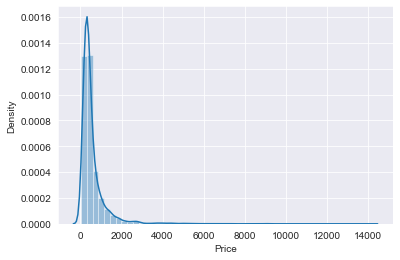

In [23]:
sns.distplot(train['Price'])

<AxesSubplot:xlabel='Price'>

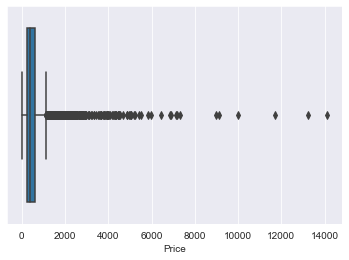

In [24]:
sns.boxplot(train['Price'])

<AxesSubplot:xlabel='reviews', ylabel='Price'>

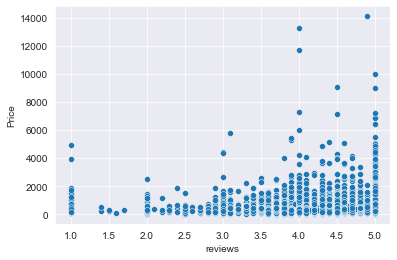

In [25]:
sns.scatterplot(train['reviews'],train['Price'])

<AxesSubplot:xlabel='ratings', ylabel='Price'>

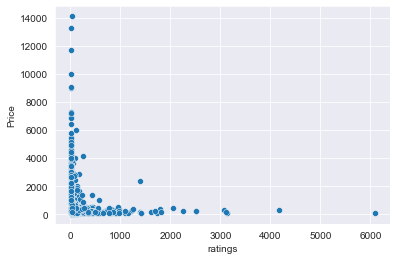

In [26]:
sns.scatterplot(train['ratings'],train['Price'])

In [27]:
train['BookCategory'].unique()

array(['Biographies, Diaries & True Accounts',
       'Computing, Internet & Digital Media', 'Sports',
       'Arts, Film & Photography', 'Humour', 'Action & Adventure',
       'Comics & Mangas', 'Politics', 'Language, Linguistics & Writing',
       'Romance', 'Crime, Thriller & Mystery'], dtype=object)

Text(0, 0.5, 'count')

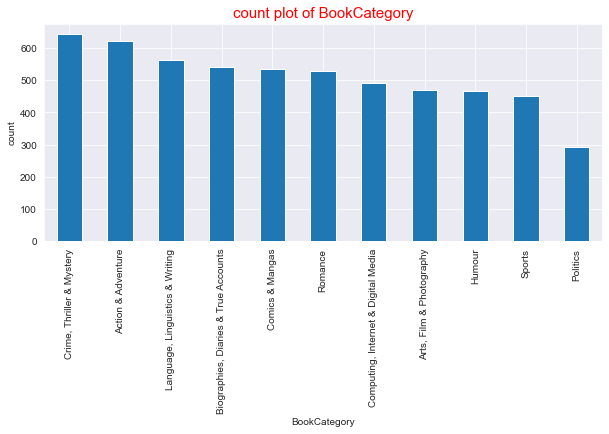

In [28]:
plt.figure(figsize=(10,4))
train['BookCategory'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title("count plot of BookCategory",fontsize=15,color='red')
plt.xlabel("BookCategory")
plt.ylabel("count")

Text(0.5, 1.0, 'Price by Category')

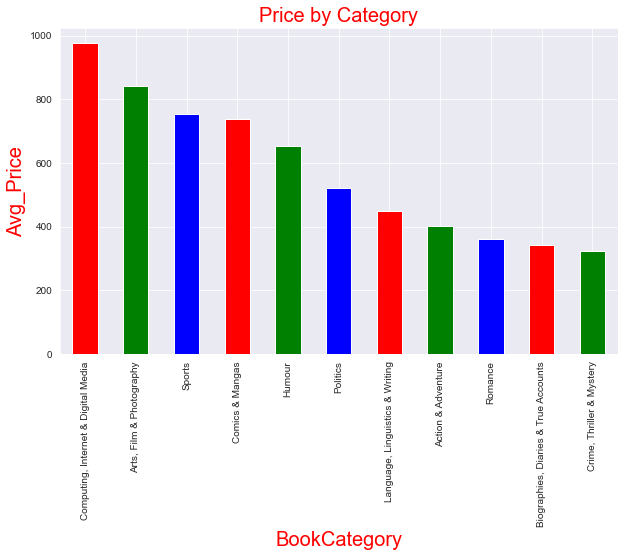

In [29]:
plt.figure(figsize=(10,6))
train.groupby('BookCategory')['Price'].mean().sort_values(ascending=False).plot(kind='bar',color=['r','g','b'])
plt.xlabel("BookCategory",color='red',fontsize=20)
plt.ylabel("Avg_Price",color='red',fontsize=20)
plt.title("Price by Category",color='red',fontsize=20)

Text(0, 0.5, 'Price')

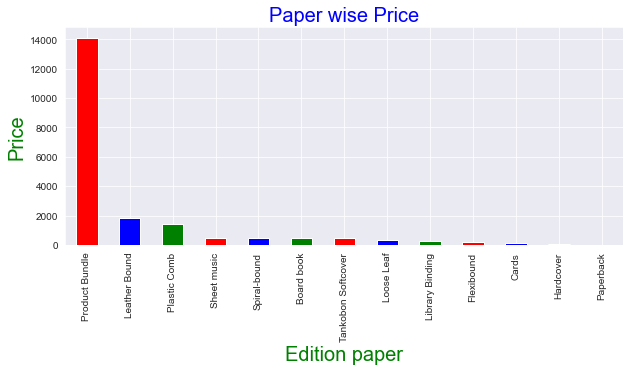

In [30]:
plt.figure(figsize=(10,4))
train.groupby(['Edition_paper'])['Price'].min().sort_values(ascending=False).plot(kind='bar',color=['red','blue','green'])
plt.title("Paper wise Price",fontsize=20,color='blue')
plt.xlabel("Edition paper",fontsize=20,color='green')
plt.ylabel("Price",fontsize=20,color='green')

In [31]:
encoded=pd.DataFrame(ohe.transform(train[ohe_cols]).toarray())

In [32]:
train.drop(ohe_cols,axis=1,inplace=True)

In [33]:
train=train.join(encoded)

In [35]:
X=train.drop("Price",axis=1)
y=train['Price']

# Model building and testing

In [48]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dropout,Dense
from keras.losses import mean_squared_error

In [49]:
mse=mean_squared_error()

TypeError: Missing required positional argument

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=45)

In [41]:
X_train.shape

(3924, 29)

In [39]:
model=Sequential()

In [42]:
model.add(Dense(units=29,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=480,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,kernel_initializer='normal',activation='linear'))


In [50]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [68]:
model.fit(X_train,y_train,epochs=300,batch_size=64,)

Epoch 1/300
62/62 [==============================] - 0s 6ms/step - loss: 416194.8438 - mean_squared_error: 416194.8438
Epoch 2/300
62/62 [==============================] - 0s 7ms/step - loss: 415385.9688 - mean_squared_error: 415385.9688
Epoch 3/300
62/62 [==============================] - 1s 8ms/step - loss: 412902.4375 - mean_squared_error: 412902.4375
Epoch 4/300
62/62 [==============================] - 1s 8ms/step - loss: 418295.7188 - mean_squared_error: 418295.7188
Epoch 5/300
62/62 [==============================] - 1s 10ms/step - loss: 415139.5312 - mean_squared_error: 415139.5312
Epoch 6/300
62/62 [==============================] - 1s 11ms/step - loss: 409449.9375 - mean_squared_error: 409449.9375
Epoch 7/300
62/62 [==============================] - 0s 6ms/step - loss: 416293.5312 - mean_squared_error: 416293.5312
Epoch 8/300
62/62 [==============================] - 0s 5ms/step - loss: 412603.9375 - mean_squared_error: 412603.9375
Epoch 9/300
62/62 [===========================

62/62 [==============================] - 0s 6ms/step - loss: 383223.0312 - mean_squared_error: 383223.0312
Epoch 70/300
62/62 [==============================] - 1s 10ms/step - loss: 379479.0625 - mean_squared_error: 379479.0625
Epoch 71/300
62/62 [==============================] - 1s 9ms/step - loss: 386710.0000 - mean_squared_error: 386710.0000
Epoch 72/300
62/62 [==============================] - 0s 6ms/step - loss: 380750.6562 - mean_squared_error: 380750.6562
Epoch 73/300
62/62 [==============================] - 0s 5ms/step - loss: 375160.8750 - mean_squared_error: 375160.8750
Epoch 74/300
62/62 [==============================] - 0s 5ms/step - loss: 378267.1250 - mean_squared_error: 378267.1250
Epoch 75/300
62/62 [==============================] - 0s 5ms/step - loss: 372561.0938 - mean_squared_error: 372561.0938
Epoch 76/300
62/62 [==============================] - 0s 5ms/step - loss: 373718.8438 - mean_squared_error: 373718.8438
Epoch 77/300
62/62 [==============================] 

62/62 [==============================] - 0s 5ms/step - loss: 364358.8438 - mean_squared_error: 364358.8438
Epoch 138/300
62/62 [==============================] - 0s 5ms/step - loss: 380748.6875 - mean_squared_error: 380748.6875
Epoch 139/300
62/62 [==============================] - 0s 5ms/step - loss: 363530.7500 - mean_squared_error: 363530.7500
Epoch 140/300
62/62 [==============================] - 0s 5ms/step - loss: 375084.7812 - mean_squared_error: 375084.7812
Epoch 141/300
62/62 [==============================] - 0s 5ms/step - loss: 378633.0938 - mean_squared_error: 378633.0938
Epoch 142/300
62/62 [==============================] - 0s 5ms/step - loss: 368267.5625 - mean_squared_error: 368267.5625
Epoch 143/300
62/62 [==============================] - 0s 5ms/step - loss: 369365.3125 - mean_squared_error: 369365.3125
Epoch 144/300
62/62 [==============================] - 0s 5ms/step - loss: 371975.6875 - mean_squared_error: 371975.6875
Epoch 145/300
62/62 [=========================

62/62 [==============================] - 0s 6ms/step - loss: 364376.2812 - mean_squared_error: 364376.2812
Epoch 205/300
62/62 [==============================] - 0s 6ms/step - loss: 369800.7188 - mean_squared_error: 369800.7188
Epoch 206/300
62/62 [==============================] - 0s 5ms/step - loss: 360857.2812 - mean_squared_error: 360857.2812
Epoch 207/300
62/62 [==============================] - 0s 5ms/step - loss: 366127.7188 - mean_squared_error: 366127.7188
Epoch 208/300
62/62 [==============================] - 0s 5ms/step - loss: 372168.9062 - mean_squared_error: 372168.9062
Epoch 209/300
62/62 [==============================] - 0s 5ms/step - loss: 367625.8750 - mean_squared_error: 367625.8750
Epoch 210/300
62/62 [==============================] - 0s 5ms/step - loss: 363192.2812 - mean_squared_error: 363192.2812
Epoch 211/300
62/62 [==============================] - 0s 7ms/step - loss: 372016.9062 - mean_squared_error: 372016.9062
Epoch 212/300
62/62 [=========================

62/62 [==============================] - 0s 7ms/step - loss: 358894.0000 - mean_squared_error: 358894.0000
Epoch 272/300
62/62 [==============================] - 0s 5ms/step - loss: 374757.1875 - mean_squared_error: 374757.1875
Epoch 273/300
62/62 [==============================] - 0s 5ms/step - loss: 359654.7188 - mean_squared_error: 359654.7188
Epoch 274/300
62/62 [==============================] - 0s 5ms/step - loss: 362693.2500 - mean_squared_error: 362693.2500
Epoch 275/300
62/62 [==============================] - 0s 5ms/step - loss: 354081.8125 - mean_squared_error: 354081.8125
Epoch 276/300
62/62 [==============================] - 0s 5ms/step - loss: 376474.2500 - mean_squared_error: 376474.2500
Epoch 277/300
62/62 [==============================] - 0s 5ms/step - loss: 359594.4375 - mean_squared_error: 359594.4375
Epoch 278/300
62/62 [==============================] - 0s 6ms/step - loss: 371925.6250 - mean_squared_error: 371925.6250
Epoch 279/300
62/62 [=========================

In [69]:
y_pred=model.predict(X_test)

In [70]:
y_pred=y_pred.reshape(1682,)

<AxesSubplot:xlabel='Price', ylabel='Density'>

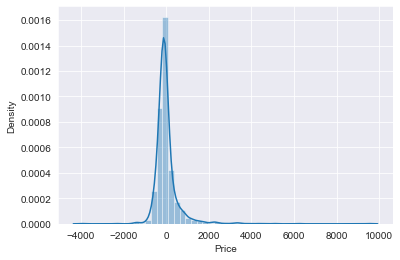

In [71]:
sns.distplot(y_test-y_pred)

In [72]:
y_test

2294    575.00
3872    334.00
2391    615.00
1896    510.00
4785    399.00
         ...  
4432    692.23
1885    224.00
4237    379.00
3249    205.00
3682    150.00
Name: Price, Length: 1682, dtype: float64

In [73]:
y_pred

array([392.46692, 401.34973, 636.8155 , ..., 395.45767, 401.34973,
       314.78433], dtype=float32)

In [74]:
r2_score(y_test,y_pred)

0.15903648601258347

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
rf=RandomForestRegressor()

In [78]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [79]:
y_pred=rf.predict(X_test)

<AxesSubplot:xlabel='Price', ylabel='Density'>

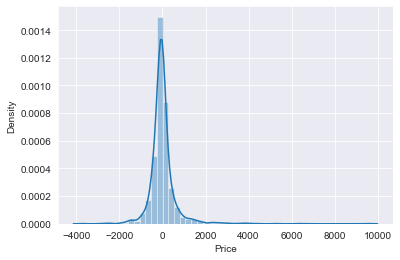

In [81]:
sns.distplot(y_test-y_pred)

In [82]:
r2_score(y_test,y_pred)

0.016759764177364578